# Introduction

This project explores what characteristics are associated with higher player engagement among games on Steam. Using several datasets that include game information, history, tags, and pricing, the goal is to understand what factors might predict a game's success in terms of player activity. 

Since continuous player data over time wasn't easily available, **peak player count** was used as a practical proxy for engagement. It captures how many players were active at the same time, which often reflects a game's popularity and visibility. 

The analysis focuses on questions that game developers or publishers might care about, such as:

1. Do games that are released in a certain month have higher player peaks?
2. Do higher-rated games tend to include achievements more often?
3. Is it a good idea to release your game as early access? Or should you wait until full release?
4. Does having a day 1 sale result in a higher peak?
5. Do higher-priced games have lower engagement?
6. Do different game tags affect engagement?

Each question is explored using appropriate visualizations and statistical tests, with conclusions based on the evidence in the data.

**Limitations**
* The dataset underrepresents highly rated games due to manual collection limits, making the rating distribution appear more balanced than it truly is on Steam.
* Player count data represents only **peak concurrent players**, not long-term activity.
* Correlation does not imply causation; results describe patterns, not guarantees.
* Some factors, like marketing, genre, or external events, are not captured in the dataset.

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway, chi2_contingency, ttest_ind
import pingouin as pg
from datetime import datetime

game_info = pd.read_parquet("../data/game_info.parquet")
game_history = pd.read_parquet("../data/game_history.parquet")
game_tags = pd.read_parquet("../data/game_tags.parquet")
days_first_discount = pd.read_parquet("../data/days_first_discount.parquet")

# Do games that are released in a certain month have higher player peaks?

In [84]:
month_extract = game_info.query("has_release_date == True").copy()
month_extract['release_month'] = month_extract['release_date'].dt.month

month_extract = month_extract[['release_month', 'peak_player_count']]

In [85]:
month_summary = (
    month_extract
    .groupby('release_month')['peak_player_count']
    .agg(["count", "mean", "median"])
)
month_summary

,count,mean,median
release_month,,,
1,589,1891.269949,45.0
2,606,6608.471947,41.0
3,695,2300.394245,38.0
4,672,2973.191964,50.5
5,723,3659.337483,48.0
6,678,2976.359882,44.0
7,670,1147.447761,42.0
8,734,3406.636240,51.0
9,682,2360.376833,46.0


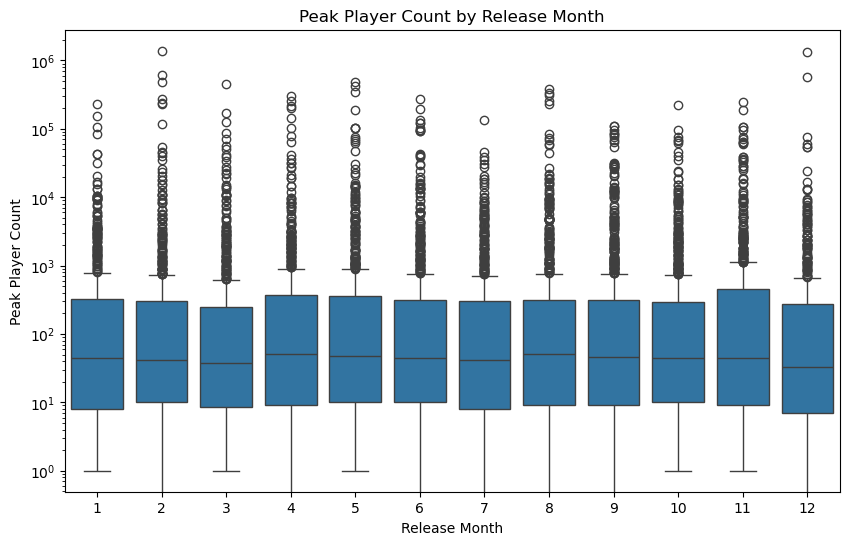

ANOVA F-statistic:  1.4492728354815616
p-value:  0.14355662237890535


In [110]:
plt.figure(figsize=(10,6))
sns.boxplot(month_extract, x="release_month", y="peak_player_count")
plt.yscale("log")
plt.ylabel("Peak Player Count")
plt.xlabel("Release Month")
plt.title("Peak Player Count by Release Month")
plt.show()

groups = [group["peak_player_count"].values for _, group in month_extract.groupby("release_month")]
stats, p = f_oneway(*groups)
print("ANOVA F-statistic: ", stats)
print("p-value: ", p)

Player peaks show no strong monthly trend; outliers are caused by blockbuster titles.

## Conclusion

The ANOVA test (F=1.45, p=0.14) indicates no statistically significant difference in peak player counts across release months. This suggests that release timing alone does not strongly influence player engagement. Although each month includes a few blockbuster outliers, most games achieve relatively modest peaks. 

# Do higher-rated games tend to include achievements more often?

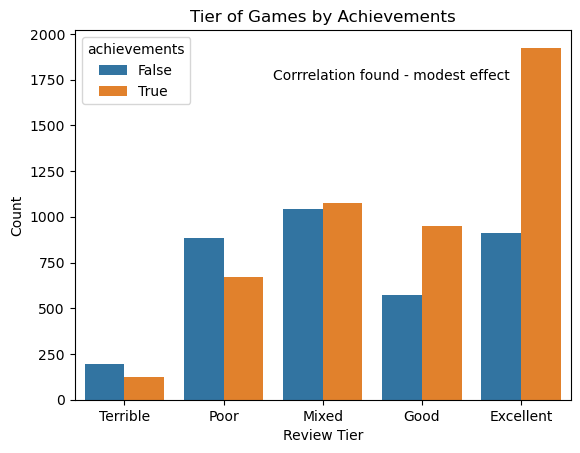

Chi2:  354.36463872494835
p-value:  2.0024469430429929e-75
Cramer's V:  0.20596999020244375


In [108]:
sns.countplot(game_info, x="review_tier", order=["Terrible", "Poor", "Mixed", "Good", "Excellent"], hue='achievements')
plt.ylabel("Count")
plt.xlabel("Review Tier")
plt.title("Tier of Games by Achievements")
plt.annotate("Corrrelation found - modest effect", xy=(1.5, 1750))
plt.show()

contingency = pd.crosstab(game_info['review_tier'], game_info['achievements'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi2: ", chi2)
print("p-value: ", p)

n = contingency.to_numpy().sum()
k = min(contingency.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))
print("Cramer's V: ", cramers_v)

## Conclusion

With the Chi-squared test (p ≈ 1e-75), we can see that there is a significant correlation between having achievements or not, depending on the review tier. However, using Cramer's V (≈ .2), this suggests that the association is not that strong. This is saying that although having achievements may contribute to more polished games, they are very unlikely to be a decisive factor in player rating. For developers, they should consider achievements as a feature rather than a way to boost reviews.

## Is it a good idea to release your game as early access? Or should you wait until full release?

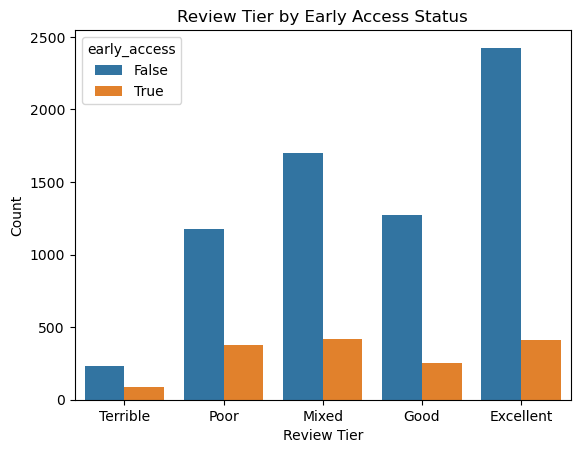

Chi2:  91.45916796039381
p-value:  6.448904302106246e-19
Cramer's V:  0.10463871129691354


In [107]:
sns.countplot(game_info, x='review_tier', order=["Terrible", "Poor", "Mixed", "Good", "Excellent"], hue='early_access')
plt.ylabel("Count")
plt.xlabel("Review Tier")
plt.title("Review Tier by Early Access Status")
plt.show()

contingency = pd.crosstab(game_info['review_tier'], game_info['early_access'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi2: ", chi2)
print("p-value: ", p)

n = contingency.to_numpy().sum()
k = min(contingency.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))
print("Cramer's V: ", cramers_v)

The p-value suggests that there is a relationship between review tier and being in early access; however, that significance is weak. 

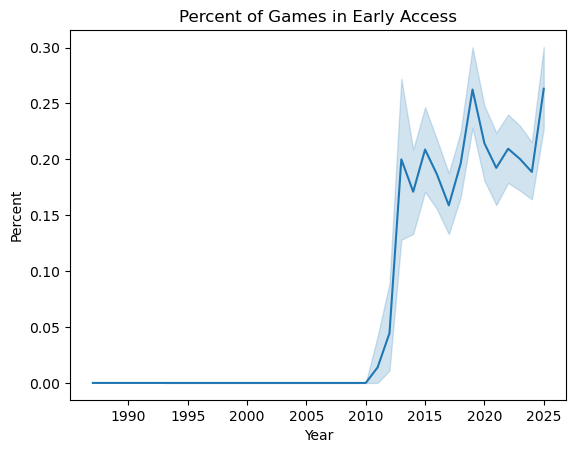

In [92]:
year_extract = game_info.query("has_release_date == True").copy()
year_extract['year'] = year_extract['release_date'].dt.year
year_extract['month'] = year_extract['release_date'].dt.month

sns.lineplot(year_extract[['early_access', 'year']], x='year', y='early_access')
plt.ylabel("Percent")
plt.xlabel("Year")
plt.title("Percent of Games in Early Access")
plt.show()

This graph shows that Early Access games were virtually nonexistent before 2010, with adoption rising sharply after 2013 — the year Steam formally launched its Early Access program (March 20, 2013). Since then, Early Access titles have consistently represented about 15–30% of new releases.

**Note**: This dataset only captures games that are still flagged as Early Access. Games that originally launched in Early Access but later left the program would not appear here as Early Access.

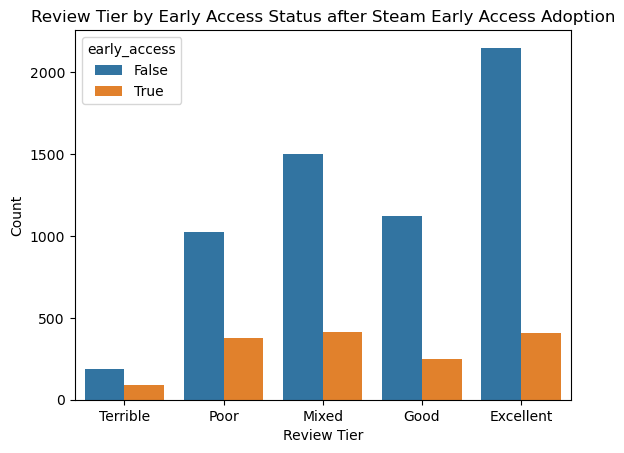

Chi2:  94.55142014576666
p-value:  1.419543343950537e-19
Cramer's V:  0.11218307335212337


In [112]:
snipped_game_info = game_info[(game_info['release_date'] > '2013-01-01')]
snipped_game_info
sns.countplot(snipped_game_info, x='review_tier', order=["Terrible", "Poor", "Mixed", "Good", "Excellent"], hue='early_access')
plt.ylabel("Count")
plt.xlabel("Review Tier")
plt.title("Review Tier by Early Access Status after Steam Early Access Adoption")
plt.show()

contingency = pd.crosstab(snipped_game_info['review_tier'], snipped_game_info['early_access'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi2: ", chi2)
print("p-value: ", p)

n = contingency.to_numpy().sum()
k = min(contingency.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))
print("Cramer's V: ", cramers_v)

Even after removing games with prior release dates to when early access games started to be placed on Steam, the chi-squared (p ≈ 1e-19) and Cramer's V (.11), there is still a strong indication that there is a big difference between having a game with early access or not.

## Conclusion

This analysis suggests that the Early Access tag itself is not strongly associated with game ratings. While Early Access games appear across all review tiers, the effect size is weak, meaning that being in Early Access alone does not determine whether a game will be rated highly or poorly.

However, it is important to note that releasing an unfinished or unpolished game, whether in Early Access or not, can negatively impact reviews. Developers should treat Early Access as a launch strategy for gathering feedback, but not as an excuse to release a low-quality product.

# Does having a day 1 sale result in a higher peak?

In [95]:
def label_day0(row):
    if row['first_sale_days'] <=1:
        return True
    elif row['first_sale_days'] > 1:
        return False

first_discount_peak = pd.merge(days_first_discount, game_info[["itad_uuid", "peak_player_count"]], on="itad_uuid", how="left")
# Some games have negative first_sale_days which means they were in early access and then had a full release
no_early_access = first_discount_peak[first_discount_peak['first_sale_days'] >=0].copy()
no_early_access['day_zero_sale'] = no_early_access.apply(label_day0, axis=1)

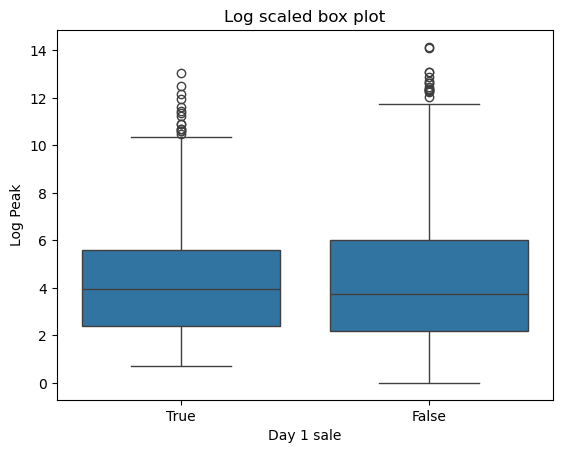

t-stat: -2.373075197910967
p-value: 0.01767473670898396


In [119]:
no_early_access['log_peak'] = np.log1p(no_early_access["peak_player_count"])
sns.boxplot(no_early_access, x="day_zero_sale", y="log_peak", order=[True, False])
plt.title("Log scaled box plot")
plt.xlabel("Day 1 sale")
plt.ylabel("Log Peak")
plt.show()

group_true = no_early_access.loc[no_early_access["day_zero_sale"], "peak_player_count"]
group_false = no_early_access.loc[~no_early_access["day_zero_sale"], "peak_player_count"]
log_true = np.log1p(group_true)
log_false = np.log1p(group_false)
t_stat, p_val = ttest_ind(log_true, log_false, equal_var=False)
print("t-stat:", t_stat)
print("p-value:", p_val)

The two box plots look very similar. However, the statistics (p ≈ 0.02) suggest that there is some significance between the two. 

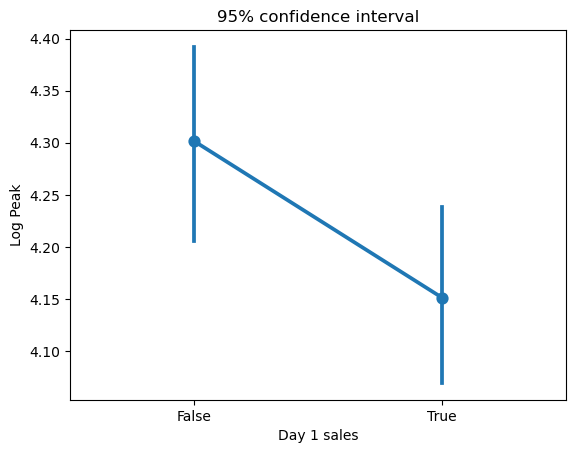

Day 1 sale games have about -14.0% lower typical peak players.


In [99]:
sns.pointplot(data=no_early_access, x="day_zero_sale", y="log_peak", errorbar=("ci", 95))
plt.title("95% confidence interval")
plt.xlabel("Day 1 sales")
plt.ylabel("Log Peak")
plt.show()

diff = no_early_access.loc[no_early_access.day_zero_sale, "log_peak"].mean() - \
       no_early_access.loc[~no_early_access.day_zero_sale, "log_peak"].mean()

ratio = np.exp(diff)   # multiplicative difference
pct = (ratio - 1) * 100
print(f"Day 1 sale games have about {pct:.1f}% lower typical peak players.")

## Conclusion

At first glance, the boxplot does not reveal a clear difference between games with and without a day-1 sale. However, a Welch's t-test shows that the difference is statistically significant (p=0.018). After applying a log transformation to account for skew, the pointplot with 95% confidence intervals highlights this difference more clearly. On average, games with a day-1 sale have about 14% typical peak player counts compared to those without. One possible explanation is that less popular games may rely on early discounts to attract players, while more anticipated titles do not need such incentives.

# Do higher-priced games have lower engagement?

In [100]:
regular_price = game_history.sort_values('regular_price', ascending=False).drop_duplicates(['itad_uuid'])
merged_reg_price = regular_price[["itad_uuid", "regular_price"]].merge(game_info, on="itad_uuid", how="left")
reg_priced = merged_reg_price[merged_reg_price["regular_price"] > 0].copy()

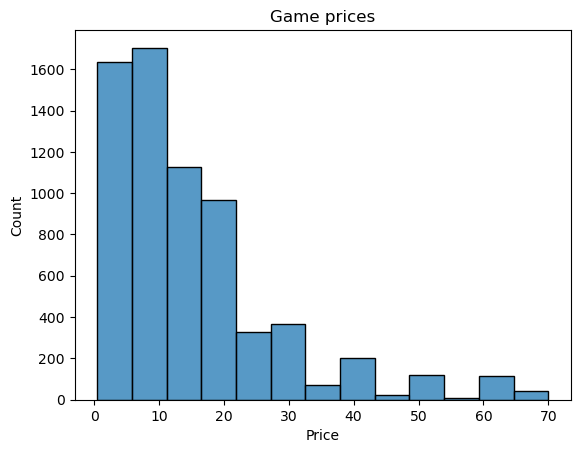

In [101]:
sns.histplot(reg_priced, x="regular_price", bins=int(max(reg_priced['regular_price']/5)))
plt.title("Game prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

Most games fall into the Free - $20 price point

In [102]:
def apply_price_tier(row):
    if row['regular_price'] == 0:
        return "free"
    if row["regular_price"] <= 5:
        return "under 5"
    if row["regular_price"] <= 10:
        return "$5-10"
    if row["regular_price"] <= 20:
        return "$10-20"
    if row["regular_price"] <= 30:
        return "$20-30"
    if row["regular_price"] > 30:
        return "$30+"

merged_reg_price["price_tier"] = merged_reg_price.apply(apply_price_tier, axis=1)
drop_na_reg_price = merged_reg_price[merged_reg_price['peak_player_count'].notna()].copy()

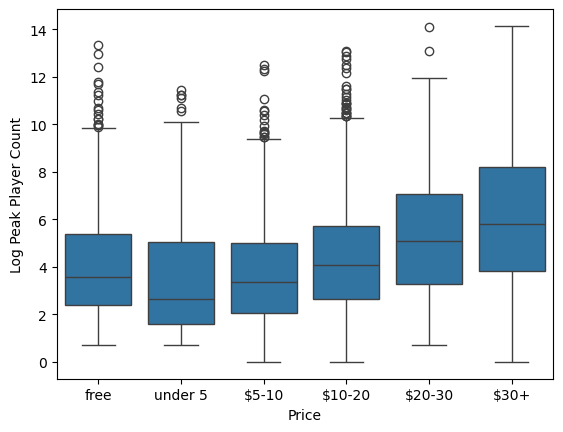

In [103]:
drop_na_reg_price['log_peak'] = np.log1p(drop_na_reg_price["peak_player_count"])
sns.boxplot(drop_na_reg_price, x="price_tier", y="log_peak", order=["free", "under 5", "$5-10", "$10-20", "$20-30", "$30+"])
plt.title("")
plt.xlabel("Price")
plt.ylabel("Log Peak Player Count")
plt.show()

After accounting for most of the blockbuster games with the log scaling, games in the cheaper tiers show lower peak player count as opposed to the mid to higher end tier price points.

In [104]:
aov = pg.anova(dv="log_peak", between="price_tier", data=drop_na_reg_price, detailed=True)
print(aov[['Source', 'p-unc', 'np2']])


       Source          p-unc       np2
0  price_tier  1.172091e-177  0.098549
1      Within            NaN       NaN


In [105]:
posthoc = pg.pairwise_tests(dv="log_peak",
                            between="price_tier",
                            data=drop_na_reg_price,
                            padjust="bonf")
hc = pd.DataFrame(posthoc[["A", "B", "T", "p-corr", "hedges"]])
hc

,A,B,T,p-corr,hedges
0,$10-20,$20-30,-9.387336,5.536872e-19,-0.440151
1,$10-20,$30+,-13.908958,3.190296e-38,-0.759527
2,$10-20,$5-10,9.108300,2.028078e-18,0.296640
3,$10-20,free,3.811284,2.115998e-03,0.131428
4,$10-20,under 5,12.293818,7.479316e-33,0.406031
5,$20-30,$30+,-5.155047,4.470042e-06,-0.293713
6,$20-30,$5-10,15.106527,8.735435e-46,0.746152
7,$20-30,free,11.494436,6.237064e-28,0.561054
8,$20-30,under 5,17.184971,5.091800e-58,0.821083
9,$30+,$5-10,18.643246,1.923928e-63,1.058102


## Conclusion

Differences in price tier are associated with about 10% of the variation in player peak counts in this dataset. This suggests that price plays a meaningful but not dominant role in game popularity. Other factors likely account for the remaining variation.

For the post-hoc comparison
* Low-range prices: `Free`, `Under 5`, `$5-10`
* Mid-range prices: `$10-20`, `$20-30`
* High-range prices: `$30+`

Post-hoc comparisons showed that higher-priced games had significantly larger peak player counts than lower tiers, with very large effect sizes (g≈1.0). Mid-range tiers also differed, but within smaller effect sizes. Differences between adjacent low-price tiers were statistically significant but practically small. This suggests that while price consistently matters, the biggest differences are between the very high-end and the lowest tiers.

# Do different game tags affect engagement?

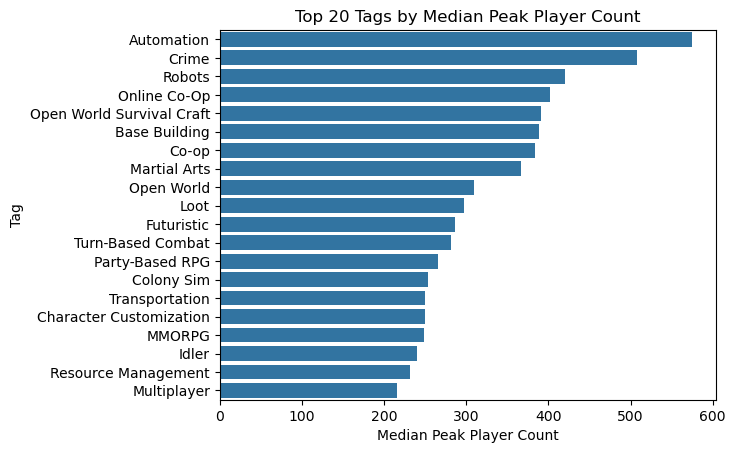

In [106]:
tag_peak = game_tags.merge(game_info, on="itad_uuid")
tag_summary = (
    tag_peak.groupby("tag")["peak_player_count"]
    .agg(["median", "count"])
    .query("count >= 15")
    .sort_values("median", ascending=False)
    .head(20)
)

sns.barplot(tag_summary, x="median", y="tag")
plt.title("Top 20 Tags by Median Peak Player Count")
plt.xlabel("Median Peak Player Count")
plt.ylabel("Tag")
plt.show()


Some tags, like “Illuminati,” show unusually high median player counts, but these results are likely due to small sample sizes or niche tags applied to a few popular games. When filtering to tags used by at least 15 titles, more general categories such as “Multiplayer” or “Open World” emerge as stronger indicators of player engagement.

It’s also worth noting that these tags come from `IsThereAnyDeal.com`, not directly from Steam, so their definitions and coverage may differ from official Steam categories. Also, `IsThereAnyDeal.com` only shows at most 5 tags, but Steam does allow for many more. Steam also only shows at most 5 tags for shoppers on the Steam page.

## Conclusion

Tags related to cooperative (`Online Co-Op`, `Co-op`, `MMORPG`, `Multiplayer`) tend to show higher typical engagement, suggesting that social or expansive gameplay may attract larger active player bases.

# Report Conclusion

This project explored what factors influence player engagement on Steam, using peak player count as a measure of popularity. 

Across multiple statistical tests and visual analyses, several key findings emerged:

* Release month showed no significant impact on engagement.
* Game Ratings and achievements were positively associated; higher-rated games more often included achievements.
* Early Access releases did not show higher peaks at launch compared to full releases.
* Pricing tends to increase with price. Mid to high-priced games showed higher typical peaks than cheaper or free titles.
* Tags such as *Online Co-op*, *Open World Survival Craft*, and *Base Building* were linked to higher median engagement, suggesting that cooperative and sandbox-style games drive interest.

Overall, the results suggest that player engagement is more influenced by gameplay design and social features than by release timing or pricing strategy.